### Урок 2

### **Домашнее задание**

1. Самостоятельно повторить tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)
3. Повторить п.2, но используя уже не медиану, а max
4. Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)
    * подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал
    * подсказка 2: нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

### Импорт необзодимых библиотек

In [1]:

import pandas as pd  # Импортируем библиотеку pandas и сокращаем её до pd
import numpy as np   # Импортируем библиотеку numpy и сокращаем её до np
import itertools     # Импортируем библиотеку itertools
from tqdm import tqdm  # Импортируем класс tqdm из библиотеки tqdm

# предобработка текстов
import nltk  # Импортируем библиотеку Natural Language Toolkit (nltk)
from nltk.corpus import stopwords  # Импортируем набор стоп-слов из библиотеки nltk
import re  # Импортируем библиотеку для работы с регулярными выражениями
from gensim.corpora.dictionary import Dictionary  # Импортируем класс Dictionary из библиотеки gensim.corpora
from gensim.test.utils import datapath  # Импортируем функцию datapath из библиотеки gensim.test.utils
from gensim.models import LdaModel  # Импортируем класс LdaModel из библиотеки gensim.models
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения 
import pymorphy2  # Морфологический анализатор



# Импортируем необходимые метрики из библиотеки sklearn.metrics
from sklearn.metrics import (
    f1_score,            # F1-мера
    roc_auc_score,       # Площадь под ROC-кривой
    precision_score,     # Точность
    classification_report,  # Отчёт о классификации
    precision_recall_curve,  # Кривая точность-полнота
    confusion_matrix       # Матрица ошибок
)

# Импортируем класс TfidfVectorizer для работы с TF-IDF векторами
from sklearn.feature_extraction.text import TfidfVectorizer

# Импортируем класс LogisticRegression для логистической регрессии
from sklearn.linear_model import LogisticRegression

# Импортируем функцию train_test_split для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split



# Импортируем библиотеку ssl для настройки контекста SSL
import ssl

# Устанавливаем не проверять сертификаты SSL
ssl._create_default_https_context = ssl._create_unverified_context

# Импортируем библиотеку matplotlib.pyplot для построения графиков
import matplotlib.pyplot as plt

# Настраиваем формат вывода графиков в виде векторных изображений (SVG)
%config InlineBackend.figure_format = 'svg'


### Загрузка датасетов 

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O ./data/articles.csv && rm -rf /tmp/cookies.txt 

--2023-10-25 22:38:20--  https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR
Resolving docs.google.com (docs.google.com)... 142.250.74.78
Connecting to docs.google.com (docs.google.com)|142.250.74.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c1sadp56p9cmntunikk5cbjk6s4edveo/1698262650000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=86b277d9-828f-419c-aaac-49473dda781b [following]
--2023-10-25 22:38:20--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c1sadp56p9cmntunikk5cbjk6s4edveo/1698262650000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=86b277d9-828f-419c-aaac-49473dda781b
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 142.250.74.129
Connecting to doc-0s-c0-docs.googleuserc

In [3]:
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O ./data/users_articles.csv

--2023-10-25 22:41:10--  https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a
Resolving drive.google.com (drive.google.com)... 142.250.74.174
Connecting to drive.google.com (drive.google.com)|142.250.74.174|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9mjks6hnmfc554bn7e3k421a8bj5l6mv/1698262800000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download&uuid=32f338e6-59d9-4711-920d-3f8a0d948bb9 [following]
--2023-10-25 22:41:11--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9mjks6hnmfc554bn7e3k421a8bj5l6mv/1698262800000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download&uuid=32f338e6-59d9-4711-920d-3f8a0d948bb9
Resolving doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 142.250.74.129
Connecting to doc-04-c0-docs.googleusercont

In [4]:
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O ./data/users_churn.csv

--2023-10-25 22:41:13--  https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK
Resolving drive.google.com (drive.google.com)... 142.250.74.174
Connecting to drive.google.com (drive.google.com)|142.250.74.174|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qm1g7jf0d7haol8v0n0l30r65qbolrpl/1698262800000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download&uuid=add47872-21ee-4e27-b022-41949903517e [following]
--2023-10-25 22:41:13--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qm1g7jf0d7haol8v0n0l30r65qbolrpl/1698262800000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download&uuid=add47872-21ee-4e27-b022-41949903517e
Resolving doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-docs.googleusercontent.com)... 142.250.74.129
Connecting to doc-0k-c0-docs.googleusercont

In [5]:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O ./data/stopwords.txt

--2023-10-25 22:41:14--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Resolving drive.google.com (drive.google.com)... 142.250.74.174
Connecting to drive.google.com (drive.google.com)|142.250.74.174|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q6pecapuqu794952brejr4c84l9qt8m8/1698262875000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=eec1fc98-0686-4886-8e62-29c7b86b0755 [following]
--2023-10-25 22:41:15--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q6pecapuqu794952brejr4c84l9qt8m8/1698262875000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=eec1fc98-0686-4886-8e62-29c7b86b0755
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 142.250.74.129
Connecting to doc-0s-c0-docs.googleusercont

### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)

In [6]:
# Присваиваем переменной FUNC функцию np.median
FUNC = np.median

In [8]:
# Загружаем данные из файла "articles.csv" в переменную news, используя библиотеку pandas
news = pd.read_csv("./data/articles.csv")

# Выводим размер (количество строк и столбцов) загруженных данных
print(news.shape)

# Выводим первые 5 строк данных, чтобы их просмотреть
news.head(5)


(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...


In [9]:
# Загружаем данные из файла "users_articles.csv" в переменную users, используя библиотеку pandas
users = pd.read_csv("./data/users_articles.csv")

# Выводим первые 5 строк данных из users, чтобы их просмотреть
users.head(5)


,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [10]:
# Загружаем список стоп-слов из библиотеки nltk
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Загружаем список стоп-слов на русском языке из библиотеки nltk
stopword_ru = stopwords.words('russian')

# Выводим количество стоп-слов в списке
print(len(stopword_ru))


151


In [12]:
# Открываем файл 'stopwords.txt' для чтения
with open('./data/stopwords.txt') as f:
    # Читаем строки из файла, удаляем лишние пробелы, и сохраняем в список additional_stopwords
    additional_stopwords = [w.strip() for w in f.readlines() if w]

# Добавляем дополнительные стоп-слова из файла к списку stopword_ru
stopword_ru += additional_stopwords

# Выводим общее количество стоп-слов в списке
len(stopword_ru)


776

In [13]:
# Создаем словарь cache для кэширования результатов морфологического анализа
cache = {}

# Инициализируем объект MorphAnalyzer из библиотеки pymorphy2 для проведения морфологического анализа текста
morph = pymorphy2.MorphAnalyzer()


In [14]:
# очистка текста
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text


# лемматизация
def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords


# Преобразование текста в формат, подходящий для LDA
def get_lda_vector(lda, text):
    '''
    Получение вектора LDA для текста
        [0] Преобразование текста в формат, подходящий для LDA
        [1] Получение распределения тем в документе
        [2] Создание словаря тем с их весами
        [3] Составление выходного вектора

    :param lda: Обученная модель LDA
    :param text: Входной текст для анализа

    :return: Вектор LDA в формате NumPy
    '''

    # [0]
    unseen_doc = common_dictionary.doc2bow(text)

    # [1]
    lda_tuple = lda[unseen_doc]

    # [2]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    # [3]
    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])

    return np.array(output_vector)


# Получение вектора пользователя на основе списка статей
def get_user_embedding(user_articles_list, doc_dict, func):
    '''
    Получение вектора пользователя на основе списка статей
        [0] Преобразование строки со списком статей пользователя в список
        [1] Извлечение векторов для каждой статьи из словаря
        [2] Вычисление вектора пользователя путем усреднения векторов статей

    :param user_articles_list: Список статей пользователя в формате строки
    :param doc_dict: Словарь, сопоставляющий идентификаторы статей их векторам

    :return: Вектор пользователя
    '''

    # [0]
    user_articles_list = eval(user_articles_list)

    # [1]
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])

    # [2]
    user_vector = func(user_vector, 0)  # Можно также не использовать среднее, а другую агрегацию

    return user_vector



# Эта функция выводит и отображает матрицу ошибок
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Эта функция выводит и отображает матрицу ошибок. 
    Нормализация может быть применена, установив `normalize=True`.

    :param cm: Матрица ошибок (confusion matrix)
    :param classes: Список классов (меток)
    :param normalize: Флаг, указывающий, следует ли нормализовать матрицу
    :param title: Заголовок графика
    :param cmap: Цветовая схема для отображения

    :return: None (график выводится на экран)
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [15]:
%%time
# Импортируем класс tqdm из библиотеки tqdm и настраиваем его для работы с pandas
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста в столбце 'title' в DataFrame news с использованием функции clean_text.
# Применение tqdm для отслеживания прогресса выполнения операции.
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))


  0%|                                                 | 0/27000 [00:00<?, ?it/s]/var/folders/mp/vvn0dpg13231sm2vqczljp_00000gn/T/ipykernel_24363/1182742010.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
100%|███████████████████████████████████| 27000/27000 [00:22<00:00, 1214.85it/s]

CPU times: user 21.9 s, sys: 325 ms, total: 22.3 s
Wall time: 22.3 s


In [16]:
%%time
# Запускаем лемматизацию текста. 
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|████████████████████████████████████| 27000/27000 [02:57<00:00, 151.77it/s]

CPU times: user 2min 56s, sys: 1.45 s, total: 2min 57s
Wall time: 2min 57s


In [17]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создаем словарь (common_dictionary) на основе текстов (texts) с использованием gensim
common_dictionary = Dictionary(texts)

# Создаем корпус (common_corpus), представляющий тексты в виде мешка слов (bag of words)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]


In [18]:
# Задаем количество тем 
N_topic = 20


In [19]:
%%time
# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=10)

CPU times: user 11min 10s, sys: 3min 56s, total: 15min 6s
Wall time: 3min 57s


In [20]:

# Определяем путь к временному файлу "model.lda" с использованием функции datapath из библиотеки gensim
temp_file = datapath("model.lda")

# Сохраняем модель LDA (Latent Dirichlet Allocation) в указанный временный файл
lda.save(temp_file)


In [21]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [22]:
# Используем модель LDA (lda) для получения списка тем с их топ-словами
x = lda.show_topics(num_topics=N_topic, num_words=15, formatted=False)

# Создаем список topics_words, содержащий пары (номер темы, список топ-слов для этой темы)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Выводим информацию о каждой теме и её топ-словах
for topic, words in topics_words:
    print(f"Тема_{topic}: " + " ".join(words))


Тема_0: новый проект система банк развитие фонд программа средство проблема ru строительство всё первый технология возможность
Тема_1: день ракета район вода операция часть изз произойти причина температура пострадать первый житель объект двигатель
Тема_2: умереть польша разместить ввс освобождение польский индия обращение сочи осложнение соболезнование русь рот реактор поляк
Тема_3: военный сила армия оборона советский боевой удар ссср испытание территория действие противник комплекс база часть
Тема_4: рубль млн рост тыс цена млрд рынок уровень составить объём около доход составлять размер вырасти
Тема_5: мозг конкурс супруг ресторан жена победитель заявка туризм fo выручка новак приобретать заработок архитектор зимний
Тема_6: украина украинский россия российский александр киев глава подчеркнуть власть всё фестиваль владимир решение новость писать
Тема_7: статья дом сотрудник данные информация произойти опубликовать область пациент научный место эксперимент около квартира помощь
Тема_

In [23]:
%%time
# Создаем DataFrame topic_matrix, в котором каждая строка представляет вектор тем для соответствующего заголовка
# в DataFrame news.
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])

# Присваиваем имена столбцам, представляющим темы, в соответствии с их номерами.
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]

# Добавляем столбец 'doc_id' с идентификаторами документов из DataFrame news к topic_matrix.
topic_matrix['doc_id'] = news['doc_id'].values

# Переупорядочиваем столбцы, чтобы 'doc_id' был первым столбцом, а затем идут столбцы с векторами тем.
topic_matrix = topic_matrix[['doc_id'] + [f'topic_{i}' for i in range(N_topic)]]

# Выводим первые 5 строк topic_matrix.
topic_matrix.head(5)


CPU times: user 1min 13s, sys: 31.5 s, total: 1min 44s
Wall time: 27.2 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.122912,0.000000,0.000000,0.0,0.0000,0.019147,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.740910,0.000000,0.000000
1,4896,0.000000,0.000000,0.019179,0.0,0.0000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.252933,0.000000,0.093060
2,4897,0.000000,0.000000,0.000000,0.0,0.0446,0.000000,0.170251,0.0,0.0,...,0.0,0.074619,0.0,0.000000,0.030874,0.0,0.020990,0.000000,0.116339,0.000000
3,4898,0.000000,0.029006,0.000000,0.0,0.0000,0.000000,0.120312,0.0,0.0,...,0.0,0.000000,0.0,0.146085,0.000000,0.0,0.063233,0.000000,0.391412,0.000000
4,4899,0.000000,0.039667,0.000000,0.0,0.0000,0.000000,0.457397,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.179306,0.000000,0.033122


### Следующий шаг - векторные представления пользователей

In [24]:
# Создаем словарь doc_dict, в котором ключами являются идентификаторы документов (doc_id),
# а значениями - соответствующие векторы тем из topic_matrix.
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))


In [25]:
%%time
# Создаем DataFrame user_embeddings, в котором каждая строка представляет вектор пользователя на основе его статей.
# Для этого используется функция get_user_embedding, а doc_dict используется для получения векторов тем для статей.
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, FUNC))])

# Присваиваем имена столбцам, представляющим темы, в соответствии с их номерами.
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]

# Добавляем столбец 'uid' с идентификаторами пользователей из DataFrame users к user_embeddings.
user_embeddings['uid'] = users['uid'].values

# Переупорядочиваем столбцы, чтобы 'uid' был первым столбцом, а затем идут столбцы с векторами тем.
user_embeddings = user_embeddings[['uid'] + [f'topic_{i}' for i in range(N_topic)]]

# Выводим первые 3 строки user_embeddings.
user_embeddings.head(3)


CPU times: user 673 ms, sys: 15 ms, total: 688 ms
Wall time: 696 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.000000,0.0,0.000000,0.016498,0.0,0.323217,0.000000,0.0,...,0.008178,0.0,0.084257,0.067076,0.020199,0.0,0.0,0.013413,0.048262,0.000000
1,u108690,0.033831,0.042101,0.0,0.000000,0.012090,0.0,0.236421,0.032336,0.0,...,0.010826,0.0,0.019923,0.151742,0.000000,0.0,0.0,0.056001,0.163010,0.005695
2,u108339,0.000000,0.153791,0.0,0.010878,0.034847,0.0,0.116151,0.074321,0.0,...,0.006746,0.0,0.022578,0.091065,0.000000,0.0,0.0,0.186932,0.070643,0.013005


In [26]:
# Загружаем данные из файла "users_churn.csv" в переменную target с помощью библиотеки pandas
target = pd.read_csv("./data/users_churn.csv")

# Выводим первые 5 строк данных, чтобы их просмотреть
target.head(5)


,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0


In [27]:
# Объединяем два DataFrame: user_embeddings и target, используя левое объединение ('left')
X = pd.merge(user_embeddings, target, 'left')

# Выводим первые 5 строк объединенного DataFrame X
X.head(5)


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.000000,0.0,0.000000,0.016498,0.0,0.323217,0.000000,0.0,...,0.0,0.084257,0.067076,0.020199,0.000000,0.000000,0.013413,0.048262,0.000000,0
1,u108690,0.033831,0.042101,0.0,0.000000,0.012090,0.0,0.236421,0.032336,0.0,...,0.0,0.019923,0.151742,0.000000,0.000000,0.000000,0.056001,0.163010,0.005695,1
2,u108339,0.000000,0.153791,0.0,0.010878,0.034847,0.0,0.116151,0.074321,0.0,...,0.0,0.022578,0.091065,0.000000,0.000000,0.000000,0.186932,0.070643,0.013005,1
3,u101138,0.038702,0.000000,0.0,0.015133,0.007924,0.0,0.048561,0.000000,0.0,...,0.0,0.033656,0.063445,0.161454,0.005001,0.000000,0.000000,0.221986,0.000000,0
4,u108248,0.016379,0.062686,0.0,0.000000,0.017832,0.0,0.128570,0.035064,0.0,...,0.0,0.000000,0.026952,0.000000,0.000000,0.005875,0.078384,0.140046,0.000000,1


In [28]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, stratify=X['churn'], 
                                                    test_size=0.25)

In [29]:
# Создаём модель логистической регрессии
logreg = LogisticRegression()

# Обучаем модель логистической регрессии на обучающих данных
logreg.fit(X_train, y_train)


LogisticRegression()

In [30]:
# Используем обученную модель логистической регрессии (logreg) для получения вероятностей прогнозов
# (в данном случае вероятности класса 1) на тестовых данных (X_test)
preds = logreg.predict_proba(X_test)[:, 1]

# Выводим первые 20 вероятностей прогнозов
preds[:20]


array([0.09578211, 0.08860182, 0.08376682, 0.03121273, 0.03012655,
       0.08544558, 0.04172616, 0.0579227 , 0.06492841, 0.00817516,
       0.0062347 , 0.02973084, 0.04934742, 0.07706567, 0.15319182,
       0.20046623, 0.00135073, 0.0692022 , 0.07513883, 0.07042802])

### Рассчитаем Precision, Recall, F_score

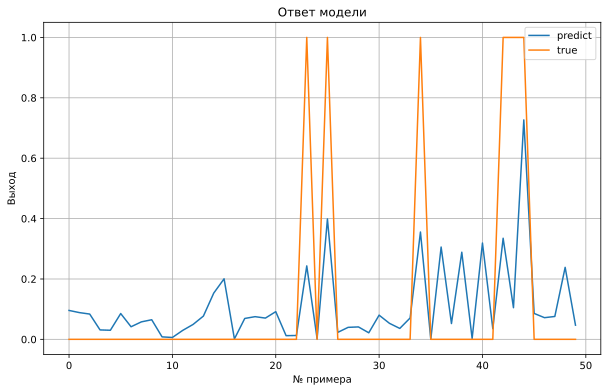

In [31]:
# Устанавливаем количество примеров (n), которые мы хотим отобразить
n = 50

# Создаем график с указанным размером
plt.figure(figsize=(10, 6))

# Строим график вероятностей прогнозов (preds) с меткой 'predict'
plt.plot(preds[:n], label='predict')

# Строим график истинных значений (y_test) с меткой 'true'
plt.plot(y_test.values[:n], label='true')

# Задаем заголовок графика
plt.title('Ответ модели')

# Задаем подписи для осей
plt.xlabel('№ примера')
plt.ylabel('Выход')

# Добавляем легенду, чтобы указать, что представляют собой линии на графике
plt.legend()

# Включаем сетку на графике
plt.grid('On')

# Отображаем график
plt.show()


In [32]:
# Вычисляем метрики точности, полноты и пороговые значения для кривой точности-полноты
precision, recall, thresholds = precision_recall_curve(y_test, preds)

# Вычисляем значение F-меры для разных порогов
fscore = (2 * precision * recall) / (precision + recall)

# Находим индекс порога, при котором F-мера максимальна
ix = np.argmax(fscore)

# Выводим оптимальный порог, значение F-меры, точности и полноты, соответствующие этому порогу
print(f'Лучший Порог={thresholds[ix]}, F-мера={fscore[ix]:.3f}, Точность={precision[ix]:.3f}, \
Полнота={recall[ix]:.3f}')
                                                                     

Лучший Порог=0.24773811257960057, F-мера=0.715, Точность=0.654, Полнота=0.788


Confusion matrix, without normalization
[[1646  104]
 [  54  196]]


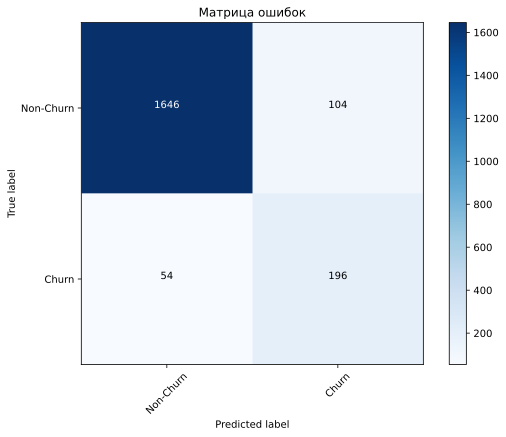

In [35]:

# Устанавливаем параметры шрифта для графиков
font = {'size': 10}
plt.rc('font', **font)

# Создаем матрицу ошибок (confusion matrix) сравнивая истинные значения (y_test) с бинарными прогнозами 
# (preds > thresholds[ix])
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

# Создаем фигуру для отображения графика матрицы ошибок
plt.figure(figsize=(8, 6))

# Вызываем функцию plot_confusion_matrix для отображения матрицы ошибок
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'Churn'],
                      title='Матрица ошибок')

# Сохраняем график в файл "conf_matrix.png"
plt.savefig("./image/conf_matrix.png")

# Отображаем график
plt.show()


In [36]:
# Вычисляем значение площади под ROC-кривой (ROC AUC) сравнивая истинные значения (y_test) и вероятности прогнозов 
# (preds)
roc_auc = roc_auc_score(y_test, preds)

# Выводим значение ROC AUC
roc_auc


0.954953142857143

In [37]:
# Создаем пустой DataFrame (metrics_df) с заданными именами столбцов
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])

# Выводим значение metrics_df
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC


In [38]:
# Создаем DataFrame, содержащий информацию о модели или настройках модели и её производительности
data_to_append = pd.DataFrame({
    'model': [FUNC.__name__],
    'thresh': [thresholds[ix]],
    'F-Score': [fscore[ix]],
    'Precision': [precision[ix]],
    'Recall': [recall[ix]],
    'ROC AUC': [roc_auc]
})

# Объединяем data_to_append с существующим DataFrame metrics_df, добавляя строки в конец (axis=0)
# и игнорируя индексы
metrics_df = pd.concat([metrics_df, data_to_append], ignore_index=True, axis=0)

# Выводим обновленный DataFrame metrics_df
metrics_df


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,median,0.247738,0.715064,0.654485,0.788,0.954953


### 3. Повторить п.2, но используя уже не медиану, а max

In [39]:
# Присваиваем переменной FUNC функцию np.max
FUNC = np.max


In [40]:
def get_user_embedding(user_articles_list, doc_dict, func):
    '''
    Получение вектора пользователя на основе списка статей
        [0] Преобразование строки со списком статей пользователя в список
        [1] Извлечение векторов для каждой статьи из словаря
        [2] Вычисление вектора пользователя путем усреднения векторов статей

    :param user_articles_list: Список статей пользователя в формате строки
    :param doc_dict: Словарь, сопоставляющий идентификаторы статей их векторам

    :return: Вектор пользователя
    '''

    # [0]
    user_articles_list = eval(user_articles_list)

    # [1]
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])

    # [2]
    user_vector = func(user_vector, 0)

    return user_vector

In [41]:
%%time
# Создаем DataFrame user_embeddings с использованием функции get_user_embedding и нового значения FUNC (np.max)
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, FUNC))])

# Присваиваем имена столбцам, представляющим темы, в соответствии с их номерами
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]

# Добавляем столбец 'uid' с идентификаторами пользователей из DataFrame users к user_embeddings
user_embeddings['uid'] = users['uid'].values

# Переупорядочиваем столбцы, чтобы 'uid' был первым столбцом, а затем идут столбцы с векторами тем
user_embeddings = user_embeddings[['uid'] + [f'topic_{i}' for i in range(N_topic)]]

# Выводим первые строки user_embeddings
user_embeddings.head()


CPU times: user 351 ms, sys: 43.9 ms, total: 395 ms
Wall time: 290 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.094993,0.096299,0.000000,0.000000,0.193642,0.000000,0.782290,0.161480,0.048500,...,0.171801,0.000000,0.175227,0.164844,0.119633,0.020086,0.123374,0.176426,0.252506,0.075693
1,u108690,0.104833,0.135866,0.079584,0.026652,0.153195,0.020424,0.368292,0.185239,0.094933,...,0.135519,0.013476,0.068712,0.506110,0.000000,0.018485,0.026966,0.358227,0.242318,0.038651
2,u108339,0.053704,0.379192,0.023266,0.067683,0.140469,0.010113,0.441307,0.222550,0.000000,...,0.037832,0.000000,0.100539,0.410368,0.000000,0.023380,0.017824,0.344540,0.197211,0.025846
3,u101138,0.184249,0.190886,0.135677,0.076618,0.176025,0.000000,0.210488,0.027488,0.000000,...,0.000000,0.010505,0.150666,0.233952,0.494677,0.114863,0.000000,0.019979,0.266202,0.028139
4,u108248,0.058606,0.603246,0.027545,0.029164,0.112975,0.000000,0.593579,0.103356,0.085615,...,0.063043,0.010666,0.122191,0.213430,0.000000,0.000000,0.065111,0.199037,0.361175,0.044614


In [42]:
# Объединяем два DataFrame: user_embeddings и target, используя левое объединение ('left')
X = pd.merge(user_embeddings, target, 'left')

# Выводим первые 5 строк объединенного DataFrame X
X.head()


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.094993,0.096299,0.000000,0.000000,0.193642,0.000000,0.782290,0.161480,0.048500,...,0.000000,0.175227,0.164844,0.119633,0.020086,0.123374,0.176426,0.252506,0.075693,0
1,u108690,0.104833,0.135866,0.079584,0.026652,0.153195,0.020424,0.368292,0.185239,0.094933,...,0.013476,0.068712,0.506110,0.000000,0.018485,0.026966,0.358227,0.242318,0.038651,1
2,u108339,0.053704,0.379192,0.023266,0.067683,0.140469,0.010113,0.441307,0.222550,0.000000,...,0.000000,0.100539,0.410368,0.000000,0.023380,0.017824,0.344540,0.197211,0.025846,1
3,u101138,0.184249,0.190886,0.135677,0.076618,0.176025,0.000000,0.210488,0.027488,0.000000,...,0.010505,0.150666,0.233952,0.494677,0.114863,0.000000,0.019979,0.266202,0.028139,0
4,u108248,0.058606,0.603246,0.027545,0.029164,0.112975,0.000000,0.593579,0.103356,0.085615,...,0.010666,0.122191,0.213430,0.000000,0.000000,0.065111,0.199037,0.361175,0.044614,1


In [43]:
# Разделяем данные на обучающие и тестовые наборы
# X[[f'topic_{i}' for i in range(N_topic)]] - признаки, которые используются для обучения и тестирования
# X['churn'] - целевая переменная (вероятно, о факте оттока пользователей)
# random_state=0 - параметр для воспроизводимости случайных разделений
# stratify=X['churn'] - стратификация по целевой переменной для сохранения баланса классов
# test_size=0.25 - доля данных, которые будут использоваться как тестовый набор (25%)

X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, stratify=X['churn'], 
                                                    test_size=0.25)


In [44]:
# Создаем модель логистической регрессии
logreg = LogisticRegression()

# Обучаем модель логистической регрессии на обучающих данных
logreg.fit(X_train, y_train)


LogisticRegression()

In [45]:
# Используем обученную модель логистической регрессии для получения вероятностей прогнозов
# (в данном случае вероятности класса 1) на тестовых данных (X_test)
preds = logreg.predict_proba(X_test)[:, 1]

# Выводим первые 20 вероятностей прогнозов
preds[:20]


array([4.26460344e-01, 2.34037291e-02, 7.74808939e-03, 4.06392324e-02,
       5.79086599e-03, 1.69224912e-01, 1.44772964e-02, 3.07549945e-02,
       1.10700204e-01, 1.97982383e-03, 9.41053015e-06, 7.03047721e-03,
       1.33204722e-01, 2.01948653e-02, 2.93264313e-01, 4.04598559e-02,
       3.24431277e-04, 1.39560571e-03, 3.20627341e-02, 1.58658198e-02])

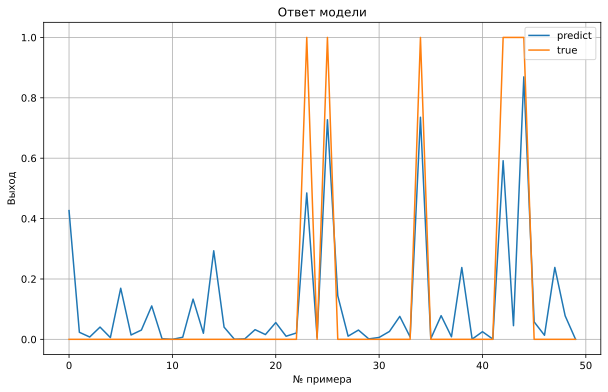

In [46]:
# Устанавливаем количество примеров (n), которые мы хотим отобразить
n = 50

# Создаем график с указанным размером
plt.figure(figsize=(10, 6))

# Строим график вероятностей прогнозов (preds) с меткой 'predict'
plt.plot(preds[:n], label='predict')

# Строим график истинных значений (y_test) с меткой 'true'
plt.plot(y_test.values[:n], label='true')

# Задаем заголовок графика
plt.title('Ответ модели')

# Задаем подписи для осей
plt.xlabel('№ примера')
plt.ylabel('Выход')

# Добавляем легенду, чтобы указать, что представляют собой линии на графике
plt.legend()

# Включаем сетку на графике
plt.grid('On')

# Отображаем график
plt.show()


In [47]:
# Вычисляем метрики точности и полноты, а также пороги для кривой точности-полноты
precision, recall, thresholds = precision_recall_curve(y_test, preds)

# Вычисляем значение F-меры для разных порогов
fscore = (2 * precision * recall) / (precision + recall)

# Находим индекс порога, при котором F-мера максимальна
ix = np.argmax(fscore)

# Выводим оптимальный порог, значение F-меры, точности и полноты, соответствующие этому порогу
print(f'Лучший Порог={thresholds[ix]}, F-мера={fscore[ix]:.3f}, Точность={precision[ix]:.3f}, \
Полнота={recall[ix]:.3f}')
                                                                       

Лучший Порог=0.3130683542249556, F-мера=0.773, Точность=0.734, Полнота=0.816


Confusion matrix, without normalization
[[1676   74]
 [  47  203]]


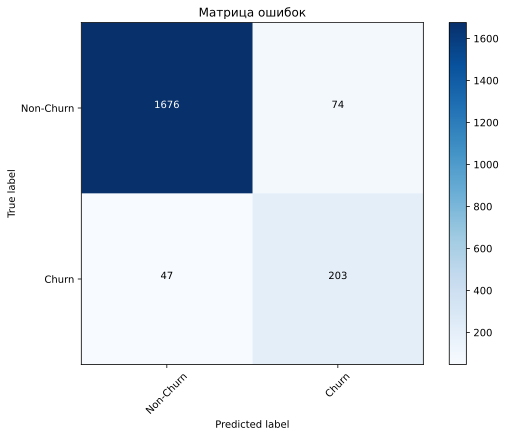

In [48]:
# Устанавливаем параметры шрифта для графиков
font = {'size': 10}
plt.rc('font', **font)

# Создаем матрицу ошибок (confusion matrix) сравнивая истинные значения (y_test) с бинарными прогнозами 
# (preds > thresholds[ix])
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

# Создаем фигуру для отображения графика матрицы ошибок
plt.figure(figsize=(8, 6))

# Вызываем функцию plot_confusion_matrix для отображения матрицы ошибок
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'Churn'],
                      title='Матрица ошибок')

# Сохраняем график в файл "conf_matrix.png"
plt.savefig("./image/conf_matrix_1.png")

# Отображаем график
plt.show()

In [49]:
# Вычисляем значение площади под ROC-кривой (ROC AUC) сравнивая истинные значения (y_test) и вероятности прогнозов 
# (preds)
roc_auc = roc_auc_score(y_test, preds)

# Выводим значение ROC AUC
roc_auc


0.962304

In [50]:
# Создаем DataFrame, содержащий информацию о модели или настройках модели и её производительности
data_to_append = pd.DataFrame({
    'model': [FUNC.__name__],
    'thresh': [thresholds[ix]],
    'F-Score': [fscore[ix]],
    'Precision': [precision[ix]],
    'Recall': [recall[ix]],
    'ROC AUC': [roc_auc]
})

# Объединяем data_to_append с существующим DataFrame metrics_df, добавляя строки в конец (axis=0)
# и игнорируя индексы
metrics_df = pd.concat([metrics_df, data_to_append], ignore_index=True, axis=0)

# Выводим обновленный DataFrame metrics_df
metrics_df


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,median,0.247738,0.715064,0.654485,0.788,0.954953
1,amax,0.313068,0.772727,0.733813,0.816,0.962304


### 4. Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)
    * подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал
    * подсказка 2: нужен именно idf, как вес.

In [51]:
# Применяем лямбда-функцию для каждого элемента в столбце "articles" в DataFrame "users"
# для удаления символов '[' ']' и ','
users['articles_str'] = users['articles'].apply(lambda x: x.replace('[','').replace(']', '').replace(',', ''))

# Выводим текст статьи для первой записи (iloc[0]) после обработки
users['articles_str'].iloc[0]


'293672 293328 293001 293622 293126 1852'

In [52]:
# Создаем объект TF-IDF-векторизации
tfidf = TfidfVectorizer()

# Обучаем TF-IDF на текстовых данных из столбца 'articles_str' в DataFrame 'users'
tfidf.fit(users['articles_str'])


TfidfVectorizer()

In [53]:
# Создаем DataFrame idf, который содержит столбцы 'article_id' и 'idf'
# 'article_id' представляет слова (термины), 'idf' представляет обратную частоту документов (IDF) для каждого 
# термина
idf = pd.DataFrame({'article_id': tfidf.get_feature_names_out(),
                    'idf': tfidf.idf_})

# Выводим DataFrame idf, который содержит информацию об IDF для каждого термина
idf


,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


In [54]:
def get_user_embedding_idf(user_articles_list, doc_dict):
    # Преобразуем строку с данными о статьях в список
    user_articles_list = eval(user_articles_list)
    
    # Создаем массив нулей для хранения вектора пользователя
    user_vector = np.zeros((len(user_articles_list), N_topic))
    
    # Для каждой статьи пользователя
    for i, doc_id in enumerate(user_articles_list):
        try:
            # Получаем значение IDF для статьи (если оно существует)
            weight = idf[idf['article_id'] == str(doc_id)]['idf'].values[0]
        except Exception as e:
            # Если IDF не найдено, устанавливаем вес равным 0
            weight = 0
        # Умножаем вектор статьи на его IDF и сохраняем результат в вектор пользователя
        user_vector[i] = doc_dict[doc_id] * weight

    # Усредняем векторы статей пользователя, чтобы получить итоговый вектор пользователя
    user_vector = np.mean(user_vector, axis=0)
    
    return user_vector


In [55]:
# Используем библиотеку tqdm для отображения прогресса выполнения
tqdm.pandas()

# Создаем DataFrame user_embeddings, в котором каждая строка представляет вектор пользователя с учетом IDF для 
# его статей
user_embeddings = pd.DataFrame([i for i in users['articles'].progress_apply(lambda x: \
                                                                            get_user_embedding_idf(x, doc_dict))])

# Присваиваем имена столбцам, представляющим темы, в соответствии с их номерами
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]

# Добавляем столбец 'uid' с идентификаторами пользователей из DataFrame users к user_embeddings
user_embeddings['uid'] = users['uid'].values

# Переупорядочиваем столбцы, чтобы 'uid' был первым столбцом, а затем идут столбцы с векторами тем
user_embeddings = user_embeddings[['uid'] + [f'topic_{i}' for i in range(N_topic)]]

# Выводим первые строки user_embeddings
user_embeddings.head()


100%|██████████████████████████████████████| 8000/8000 [01:02<00:00, 128.83it/s]


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.162845,0.138046,0.000000,0.000000,0.541618,0.000000,3.290629,0.231482,0.130167,...,0.321650,0.000000,0.677732,0.667736,0.310280,0.028793,0.253486,0.454946,0.777859,0.196100
1,u108690,0.351522,0.499395,0.117900,0.063665,0.468712,0.030258,1.949392,0.461371,0.221191,...,0.287438,0.017496,0.226314,1.534701,0.000000,0.025249,0.039948,0.854064,1.138489,0.094089
2,u108339,0.104783,1.505708,0.032487,0.156887,0.351358,0.015665,1.336554,0.793659,0.000000,...,0.122624,0.000000,0.277904,1.192929,0.000000,0.052537,0.024346,1.541645,0.628066,0.102761
3,u101138,0.478798,0.266537,0.185324,0.243284,0.311420,0.000000,0.647285,0.038381,0.000000,...,0.000000,0.014350,0.420196,0.727658,1.830802,0.205415,0.000000,0.044578,1.509772,0.040337
4,u108248,0.181950,1.446206,0.070688,0.064024,0.263775,0.000000,1.989810,0.324891,0.137740,...,0.206714,0.014893,0.243089,0.621554,0.000000,0.000000,0.125508,0.773478,1.364908,0.059793


In [56]:
# Объединяем два DataFrame: user_embeddings и target, используя левое объединение ('left')
X = pd.merge(user_embeddings, target, 'left')

# Выводим первые строки объединенного DataFrame X
X.head()


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.162845,0.138046,0.000000,0.000000,0.541618,0.000000,3.290629,0.231482,0.130167,...,0.000000,0.677732,0.667736,0.310280,0.028793,0.253486,0.454946,0.777859,0.196100,0
1,u108690,0.351522,0.499395,0.117900,0.063665,0.468712,0.030258,1.949392,0.461371,0.221191,...,0.017496,0.226314,1.534701,0.000000,0.025249,0.039948,0.854064,1.138489,0.094089,1
2,u108339,0.104783,1.505708,0.032487,0.156887,0.351358,0.015665,1.336554,0.793659,0.000000,...,0.000000,0.277904,1.192929,0.000000,0.052537,0.024346,1.541645,0.628066,0.102761,1
3,u101138,0.478798,0.266537,0.185324,0.243284,0.311420,0.000000,0.647285,0.038381,0.000000,...,0.014350,0.420196,0.727658,1.830802,0.205415,0.000000,0.044578,1.509772,0.040337,0
4,u108248,0.181950,1.446206,0.070688,0.064024,0.263775,0.000000,1.989810,0.324891,0.137740,...,0.014893,0.243089,0.621554,0.000000,0.000000,0.125508,0.773478,1.364908,0.059793,1


In [57]:
# Разделяем данные на обучающие и тестовые наборы
# X[[f'topic_{i}' for i in range(N_topic)]] - признаки, которые используются для обучения и тестирования
# X['churn'] - целевая переменная (вероятно, о факте оттока пользователей)
# random_state=0 - параметр для воспроизводимости случайных разделений
                                                      
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, stratify=X['churn'], 
                                                    test_size=0.25)


In [58]:
# Создаем модель логистической регрессии
model = LogisticRegression()

# Обучаем модель логистической регрессии на обучающих данных
model.fit(X_train, y_train)


LogisticRegression()

In [59]:

# Используем обученную модель логистической регрессии для получения вероятностей прогнозов
# (в данном случае вероятности класса 1) на тестовых данных (X_test)
preds = model.predict_proba(X_test)[:, 1]

# Выводим первые 10 вероятностей прогнозов
preds[:10]


array([1.05807441e-03, 4.52370461e-02, 5.69511265e-08, 1.23188372e-04,
       1.08484127e-04, 1.55489432e-02, 7.72643897e-04, 1.86783811e-01,
       1.70596247e-02, 1.50171717e-07])

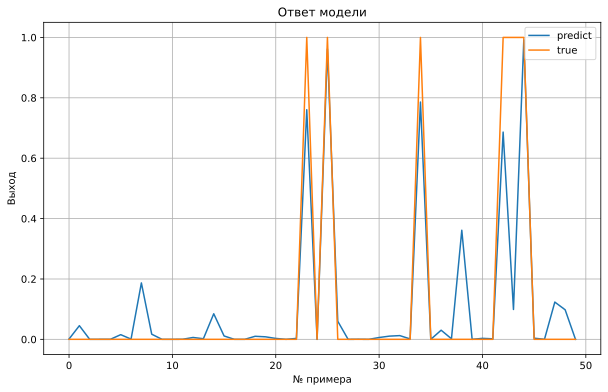

In [60]:
# Устанавливаем количество примеров (n), которые мы хотим отобразить
n = 50

# Создаем график с указанным размером
plt.figure(figsize=(10, 6))

# Строим график вероятностей прогнозов (preds) с меткой 'predict'
plt.plot(preds[:n], label='predict')

# Строим график истинных значений (y_test) с меткой 'true'
plt.plot(y_test.values[:n], label='true')

# Задаем заголовок графика
plt.title('Ответ модели')

# Задаем подписи для осей
plt.xlabel('№ примера')
plt.ylabel('Выход')

# Добавляем легенду, чтобы указать, что представляют собой линии на графике
plt.legend()

# Включаем сетку на графике
plt.grid('On')

# Отображаем график
plt.show()


In [61]:
# Вычисляем метрики точности и полноты, а также пороги для кривой точности-полноты
precision, recall, thresholds = precision_recall_curve(y_test, preds)

# Вычисляем значение F-меры для разных порогов
fscore = (2 * precision * recall) / (precision + recall)

# Находим индекс порога, при котором F-мера максимальна
ix = np.argmax(fscore)

# Выводим оптимальный порог, значение F-меры, точности и полноты, соответствующие этому порогу
print(f'Лучший Порог={thresholds[ix]}, F-мера={fscore[ix]:.3f}, Точность={precision[ix]:.3f}, \
Полнота={recall[ix]:.3f}')
                                                                       

Лучший Порог=0.40219999390429906, F-мера=0.875, Точность=0.852, Полнота=0.900


Confusion matrix, without normalization
[[1711   39]
 [  26  224]]


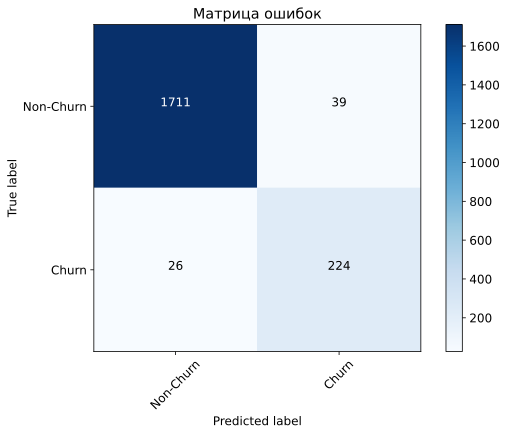

In [62]:
# Устанавливаем параметры шрифта для графиков
font = {'size': 12}
plt.rc('font', **font)

# Создаем матрицу ошибок (confusion matrix) сравнивая истинные значения (y_test) с бинарными прогнозами 
# (preds > thresholds[ix])
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

# Создаем фигуру для отображения графика матрицы ошибок
plt.figure(figsize=(8, 6))

# Вызываем функцию plot_confusion_matrix для отображения матрицы ошибок
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'Churn'],
                      title='Матрица ошибок')

# Сохраняем график в файл "conf_matrix.png"
plt.savefig("./image/conf_matrix_2.png")

# Отображаем график
plt.show()

In [63]:
# Вычисляем значение площади под ROC-кривой (ROC AUC) сравнивая истинные значения (y_test) и вероятности прогнозов 
# (preds)
roc_auc = roc_auc_score(y_test, preds)

# Выводим значение ROC AUC
roc_auc


0.9878468571428571

In [64]:
# Создаем DataFrame, содержащий информацию о модели или настройках модели и её производительности
data_to_append = pd.DataFrame({
    'model': ['idf_mean'],
    'thresh': [thresholds[ix]],
    'F-Score': [fscore[ix]],
    'Precision': [precision[ix]],
    'Recall': [recall[ix]],
    'ROC AUC': [roc_auc]
})

# Объединяем data_to_append с существующим DataFrame metrics_df, добавляя строки в конец (axis=0)
# и игнорируя индексы
metrics_df = pd.concat([metrics_df, data_to_append], ignore_index=True, axis=0)

# Выводим обновленный DataFrame metrics_df
metrics_df


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,median,0.247738,0.715064,0.654485,0.788,0.954953
1,amax,0.313068,0.772727,0.733813,0.816,0.962304
2,idf_mean,0.402200,0.875486,0.852273,0.900,0.987847


### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Исходя из полученных метрик, можно сделать вывод, что применение TFIDF показало наилучшие результаты среди рассмотренных методов. Модель "idf_mean", которая использует взвешивание TF-IDF и среднее значение векторов пользователей, продемонстрировала самые высокие метрики качества, включая F-Score, Precision, Recall и ROC AUC. Это указывает на то, что TF-IDF может эффективно выделять важные сигналы и улучшать способность модели разделять классы. В контексте задачи анализа данных и прогнозирования оттока, использование TF-IDF представляется наилучшим выбором для достижения высокой производительности модели.